In [3]:
import pandas as pd
import os
import numpy as np

import tensorflow as tf
from tensorflow import keras

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#---------------------------------------------------------------------
#Function to convert Flower names to numeric values
#---------------------------------------------------------------------
def type_to_numeric(x):
    if x=='setosa':
        return 0
    if x=='versicolor':
        return 1
    else :
        return 2

#---------------------------------------------------------------------
#Function to read data and process. Get ready for Deep Learning
#---------------------------------------------------------------------
def get_data():
    
    iris_data = pd.read_csv("iris.csv")
    
    iris_data.dtypes
    iris_data.describe()
    iris_data.head()
    
    #Use a Label encoder to convert String to numeric values for the target variable

    label_encoder = preprocessing.LabelEncoder()
    iris_data['Species'] = label_encoder.fit_transform(
                                    iris_data['Species'])
    
    #Convert input to numpy array
    np_iris = iris_data.to_numpy()
    
    #Separate feature and target variables
    X_data = np_iris[:,0:4]
    Y_data=np_iris[:,4]
    
    #Create a scaler model that is fit on the input data.
    scaler = StandardScaler().fit(X_data)
    
    #Scale the numeric feature variables
    X_data = scaler.transform(X_data)
    
    #Convert target variable as a one-hot-encoding array
    Y_data = tf.keras.utils.to_categorical(Y_data,3)

    #Return Feature and Target variables
    return X_data,Y_data

#---------------------------------------------------------------------
#Function to create the default configuration for the model. This will be overridden as 
#required during experimentation
#---------------------------------------------------------------------
def base_model_config():
    model_config = {
            "HIDDEN_NODES" : [32,64],
            "HIDDEN_ACTIVATION" : "relu",
            "OUTPUT_NODES" : 3,
            "OUTPUT_ACTIVATION" : "softmax",
            "WEIGHTS_INITIALIZER" : "random_normal",
            "BIAS_INITIALIZER" : "zeros",
            "NORMALIZATION" : "none",
            "OPTIMIZER" : "rmsprop",
            "LEARNING_RATE" : 0.001,
            "REGULARIZER" : None,
            "DROPOUT_RATE" : 0.0,
            "EPOCHS" : 10,
            "BATCH_SIZE" : 16,
            "VALIDATION_SPLIT" : 0.2,
            "VERBOSE" : 0,
            "LOSS_FUNCTION" : "categorical_crossentropy",
            "METRICS" : ["accuracy"]
            }
    return model_config

#---------------------------------------------------------------------
# Function to create an optimizer based on the optimizer name and learning rate
#---------------------------------------------------------------------
def get_optimizer(optimizer_name, learning_rate):
    #'sgd','rmsprop','adam','adagrad'
    optimizer=None
    
    if optimizer_name == 'adagrad': 
        optimizer = keras.optimizers.Adagrad(learning_rate=learning_rate)

    elif 'rmsprop':
        optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate)

    elif'adam' :
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
        
    else :
        optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
            
    return optimizer
    
    
#---------------------------------------------------------------------
# Function to create a model and fit the model
#---------------------------------------------------------------------

def create_and_run_model(model_config,X,Y,model_name) :
    
    model=tf.keras.models.Sequential(name=model_name)
    
    for layer in range(len(model_config["HIDDEN_NODES"])):
        
        if (layer == 0):
            model.add(
                    keras.layers.Dense(model_config["HIDDEN_NODES"][layer],
                    input_shape=(X.shape[1],),
                    name="Dense-Layer-" + str(layer),
                    kernel_initializer = model_config["WEIGHTS_INITIALIZER"],
                    bias_initializer = model_config["BIAS_INITIALIZER"],
                    kernel_regularizer=model_config["REGULARIZER"],
                    activation=model_config["HIDDEN_ACTIVATION"]))
        else:
            
            if ( model_config["NORMALIZATION"] == "batch"):
                model.add(keras.layers.BatchNormalization())
                
            if ( model_config["DROPOUT_RATE"] > 0.0 ):
                model.add(keras.layers.Dropout(model_config["DROPOUT_RATE"]))
                
            model.add(
                    keras.layers.Dense(model_config["HIDDEN_NODES"][layer],
                    name="Dense-Layer-" + str(layer),
                    kernel_initializer = model_config["WEIGHTS_INITIALIZER"],
                    bias_initializer = model_config["BIAS_INITIALIZER"],
                    kernel_regularizer=model_config["REGULARIZER"],
                    activation=model_config["HIDDEN_ACTIVATION"])) 
            

            
    model.add(keras.layers.Dense(model_config["OUTPUT_NODES"],
                    name="Output-Layer",
                    activation=model_config["OUTPUT_ACTIVATION"]))
    
    optimizer = get_optimizer( model_config["OPTIMIZER"],
                              model_config["LEARNING_RATE"])
    
    model.compile(loss=model_config["LOSS_FUNCTION"],
                  optimizer=optimizer,
                   metrics=model_config["METRICS"])
    
    print("\n******************************************************")
    model.summary()
    
    X_train, X_val, Y_train, Y_val =train_test_split(
                        X,Y,
                        stratify=Y,
                        test_size=model_config["VALIDATION_SPLIT"]) 
    
    history=model.fit(X_train,
          Y_train,
          batch_size=model_config["BATCH_SIZE"],
          epochs=model_config["EPOCHS"],
          verbose=model_config["VERBOSE"],
          validation_data= (X_val, Y_val))
    
    return history

#---------------------------------------------------------------------
#Function to plot a graph based on the results derived
#---------------------------------------------------------------------

def plot_graph(accuracy_measures, title):
    
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(15, 8))
    for experiment in accuracy_measures.keys():
        plt.plot(accuracy_measures[experiment], 
                 label=experiment,
                    linewidth=3)
        
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()
    

C:\Users\Karthi\AppData\Local\Temp\ipykernel_22076\1570809487.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## 2.2 Epoch and Batch Sizes

In [4]:
#Initialize the measures
accuracy_measures = {}

for batch_size in range(16,128,16):
    
    #Load default configuration
    model_config = base_model_config()
    #Acquire and process input data
    X,Y = get_data()
    
    #set epoch to 20
    model_config["EPOCHS"]=20
    #Set batch size to experiment value
    model_config["BATCH_SIZE"] = batch_size
    model_name = "Batch-Size-" + str(batch_size)
    history=create_and_run_model(model_config,X,Y,model_name)
    
    accuracy_measures[model_name] = history.history["accuracy"]


c:\Users\Karthi\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



******************************************************


Model: "Batch-Size-16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Dense-Layer-0 (Dense)           │ (None, 32)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense-Layer-1 (Dense)           │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output-Layer (Dense)            │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,467 (9.64 KB)

 Trainable params: 2,467 (9.64 KB)

 Non-trainable params: 0 (0.00 B)


******************************************************


c:\Users\Karthi\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "Batch-Size-32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Dense-Layer-0 (Dense)           │ (None, 32)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense-Layer-1 (Dense)           │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output-Layer (Dense)            │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,467 (9.64 KB)

 Trainable params: 2,467 (9.64 KB)

 Non-trainable params: 0 (0.00 B)


******************************************************


c:\Users\Karthi\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "Batch-Size-48"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Dense-Layer-0 (Dense)           │ (None, 32)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense-Layer-1 (Dense)           │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output-Layer (Dense)            │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,467 (9.64 KB)

 Trainable params: 2,467 (9.64 KB)

 Non-trainable params: 0 (0.00 B)


******************************************************


c:\Users\Karthi\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "Batch-Size-64"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Dense-Layer-0 (Dense)           │ (None, 32)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense-Layer-1 (Dense)           │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output-Layer (Dense)            │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,467 (9.64 KB)

 Trainable params: 2,467 (9.64 KB)

 Non-trainable params: 0 (0.00 B)


******************************************************


c:\Users\Karthi\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "Batch-Size-80"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Dense-Layer-0 (Dense)           │ (None, 32)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense-Layer-1 (Dense)           │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output-Layer (Dense)            │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,467 (9.64 KB)

 Trainable params: 2,467 (9.64 KB)

 Non-trainable params: 0 (0.00 B)


******************************************************


c:\Users\Karthi\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "Batch-Size-96"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Dense-Layer-0 (Dense)           │ (None, 32)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense-Layer-1 (Dense)           │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output-Layer (Dense)            │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,467 (9.64 KB)

 Trainable params: 2,467 (9.64 KB)

 Non-trainable params: 0 (0.00 B)


******************************************************


c:\Users\Karthi\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "Batch-Size-112"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Dense-Layer-0 (Dense)           │ (None, 32)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense-Layer-1 (Dense)           │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output-Layer (Dense)            │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,467 (9.64 KB)

 Trainable params: 2,467 (9.64 KB)

 Non-trainable params: 0 (0.00 B)

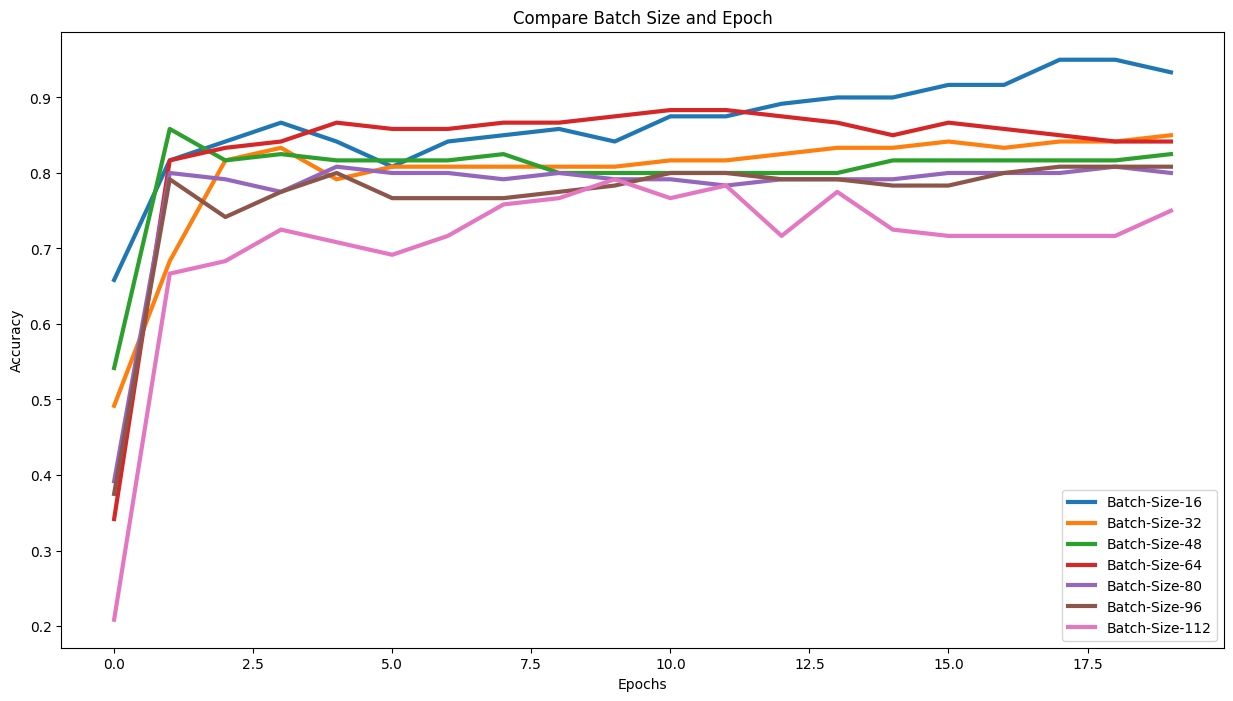

In [5]:
plot_graph(accuracy_measures, "Compare Batch Size and Epoch")

## 2.3. Layers in a Network

In [8]:
accuracy_measures = {}
layer_list =[]
for layer_count in range(1,6):
    
    #32 nodes in each layer
    layer_list.append(32)
    
    model_config = base_model_config()
    X,Y = get_data()
    
    model_config["HIDDEN_NODES"] = layer_list
    model_name = "Layers-" + str(layer_count)
    history=create_and_run_model(model_config,X,Y,model_name)
    
    accuracy_measures[model_name] = history.history["accuracy"]




******************************************************
Model: "Layers-1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense-Layer-0 (Dense)       (None, 32)                160       
                                                                 
 Output-Layer (Dense)        (None, 3)                 99        
                                                                 
Total params: 259
Trainable params: 259
Non-trainable params: 0
_________________________________________________________________

******************************************************
Model: "Layers-2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense-Layer-0 (Dense)       (None, 32)                160       
                                                                 
 Dense-Layer-1 (Dense)       (None, 32)                1056   

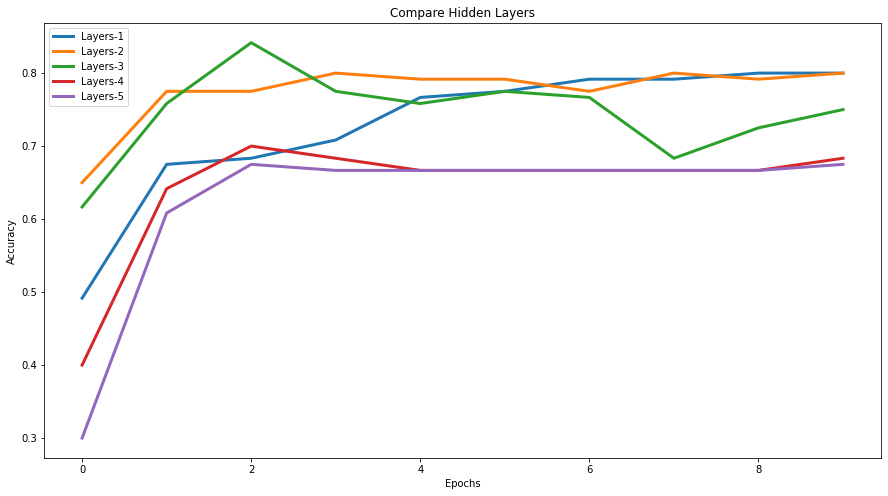

In [9]:
plot_graph(accuracy_measures, "Compare Hidden Layers")

## 2.4 Nodes in a Layer

In [16]:
accuracy_measures = {}

for node_count in range(8,40,8):
    
    #have 2 hidden layers in the networks
    layer_list =[]
    for layer_count in range(2):
        layer_list.append(node_count)
    
    model_config = base_model_config()
    X,Y = get_data()
    
    model_config["HIDDEN_NODES"] = layer_list
    model_name = "Nodes-" + str(node_count)
    history=create_and_run_model(model_config,X,Y, model_name)
    
    accuracy_measures[model_name] = history.history["accuracy"]



******************************************************
Model: "Nodes-8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense-Layer-0 (Dense)       (None, 8)                 40        
                                                                 
 Dense-Layer-1 (Dense)       (None, 8)                 72        
                                                                 
 Output-Layer (Dense)        (None, 3)                 27        
                                                                 
Total params: 139
Trainable params: 139
Non-trainable params: 0
_________________________________________________________________

******************************************************
Model: "Nodes-16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense-Layer-0 (Dense)       (None, 16)                80      

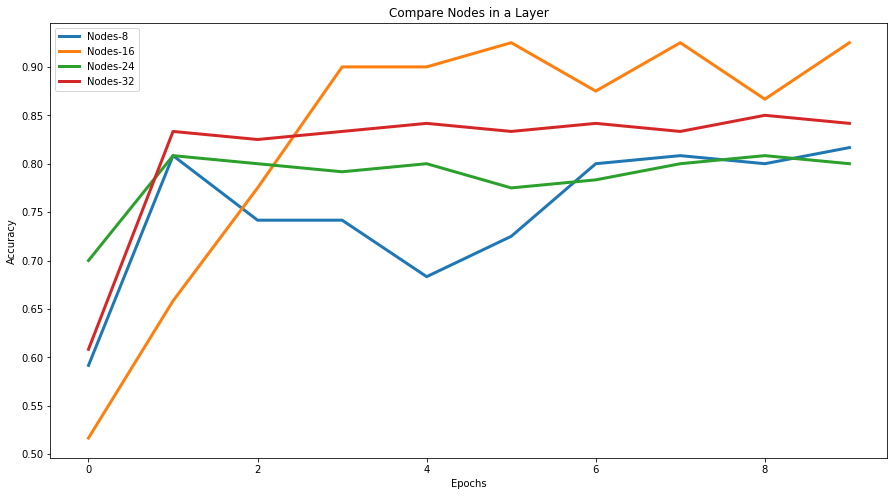

In [17]:

plot_graph(accuracy_measures, "Compare Nodes in a Layer")

## 2.5 Choosing Activation Functions

In [12]:
accuracy_measures = {}

activation_list = ['relu','sigmoid','tanh']

for activation in activation_list:
    
    model_config = base_model_config()
    X,Y = get_data()
    
    model_config["HIDDEN_ACTIVATION"] = activation
    model_name = "Model-" + activation
    history=create_and_run_model(model_config,X,Y,model_name)
    
    accuracy_measures["Model-" + activation] = history.history["accuracy"]



******************************************************
Model: "Model-relu"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense-Layer-0 (Dense)       (None, 32)                160       
                                                                 
 Dense-Layer-1 (Dense)       (None, 64)                2112      
                                                                 
 Output-Layer (Dense)        (None, 3)                 195       
                                                                 
Total params: 2,467
Trainable params: 2,467
Non-trainable params: 0
_________________________________________________________________

******************************************************
Model: "Model-sigmoid"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense-Layer-0 (Dense)       (None, 32)            

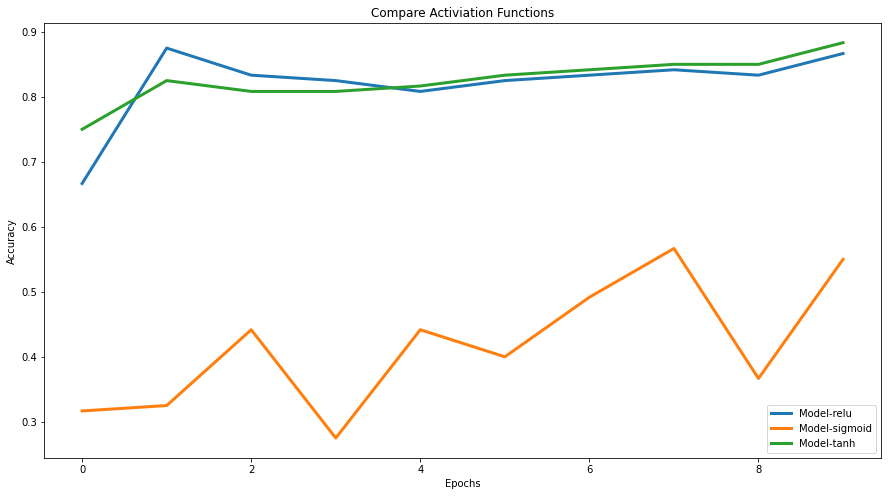

In [13]:

plot_graph(accuracy_measures, "Compare Activiation Functions")

## 2.6. Weights Initialization

In [14]:
accuracy_measures = {}

initializer_list = ['random_normal','zeros','ones',"random_uniform"]
for initializer in initializer_list:
    
    model_config = base_model_config()
    X,Y = get_data()
    
    model_config["WEIGHTS_INITIALIZER"] = initializer
    model_name = "Model-" + initializer
    history=create_and_run_model(model_config,X,Y, model_name)
    
    accuracy_measures[model_name] = history.history["accuracy"]





******************************************************
Model: "Model-random_normal"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense-Layer-0 (Dense)       (None, 32)                160       
                                                                 
 Dense-Layer-1 (Dense)       (None, 64)                2112      
                                                                 
 Output-Layer (Dense)        (None, 3)                 195       
                                                                 
Total params: 2,467
Trainable params: 2,467
Non-trainable params: 0
_________________________________________________________________

******************************************************
Model: "Model-zeros"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense-Layer-0 (Dense)       (None, 32)     

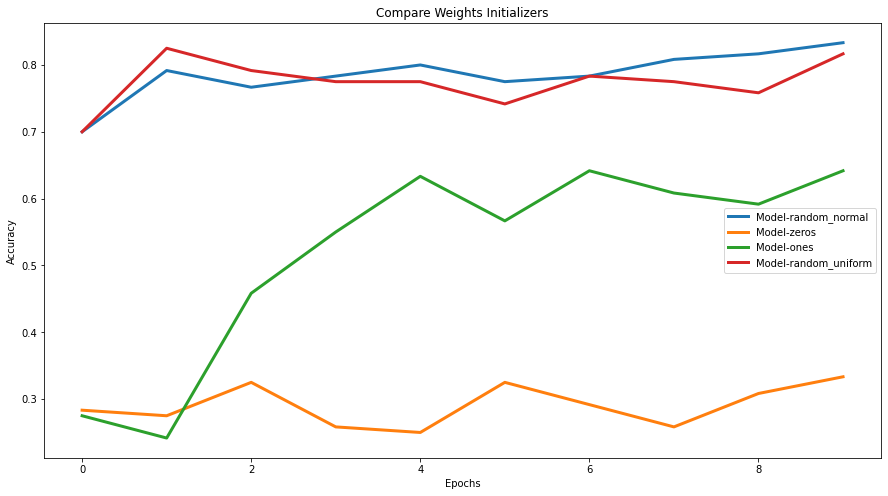

In [15]:
plot_graph(accuracy_measures, "Compare Weights Initializers")

## 3.2. Batch Normalization 

In [7]:
accuracy_measures = {}

normalization_list = ['none','batch']
for normalization in normalization_list:
    
    model_config = base_model_config()
    X,Y = get_data()
    
    model_config["NORMALIZATION"] = normalization
    model_name="Normalization-" + normalization
    history=create_and_run_model(model_config,X,Y,model_name)
    
    accuracy_measures[model_name] = history.history["accuracy"]

c:\Users\Karthi\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



******************************************************


Model: "Normalization-none"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Dense-Layer-0 (Dense)           │ (None, 32)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense-Layer-1 (Dense)           │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output-Layer (Dense)            │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,467 (9.64 KB)

 Trainable params: 2,467 (9.64 KB)

 Non-trainable params: 0 (0.00 B)


******************************************************


c:\Users\Karthi\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "Normalization-batch"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Dense-Layer-0 (Dense)           │ (None, 32)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense-Layer-1 (Dense)           │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output-Layer (Dense)            │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,595 (10.14 KB)

 Trainable params: 2,531 (9.89 KB)

 Non-trainable params: 64 (256.00 B)

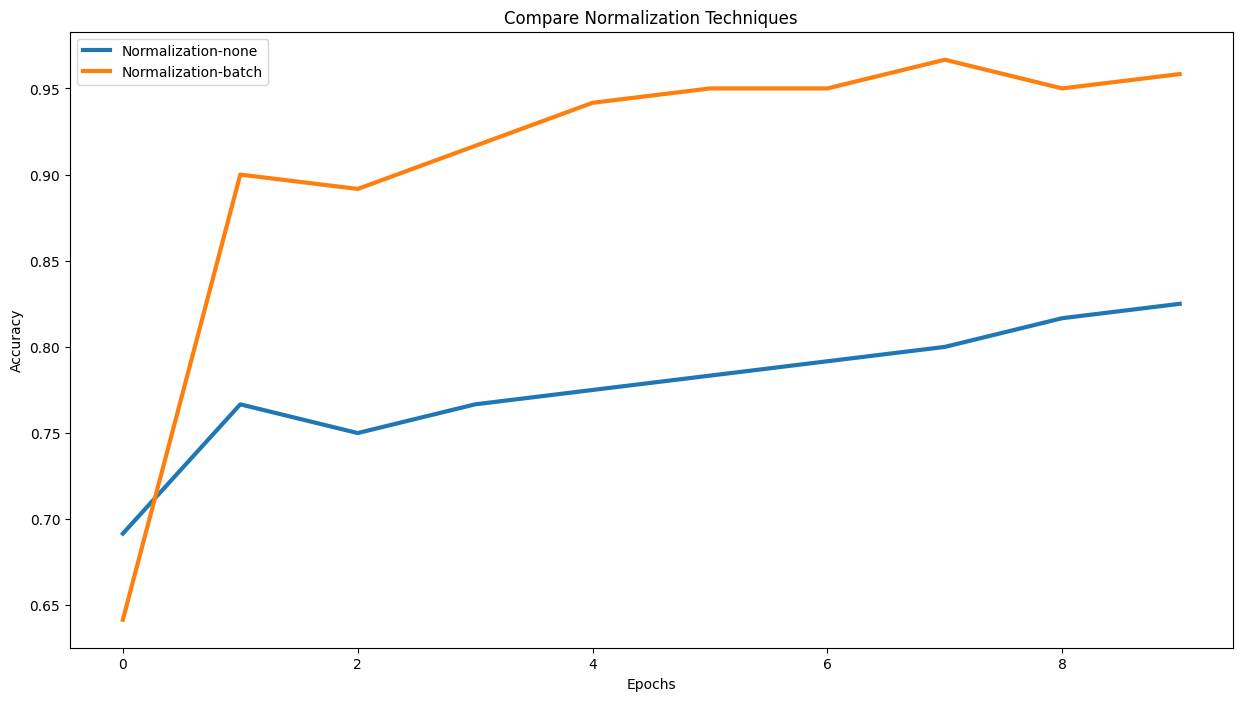

In [8]:
plot_graph(accuracy_measures, "Compare Normalization Techniques")

## 3.4 Optimizers

In [9]:

accuracy_measures = {}

optimizer_list = ['sgd','rmsprop','adam','adagrad']
for optimizer in optimizer_list:
    
    model_config = base_model_config()
    X,Y = get_data()
    
    model_config["OPTIMIZER"] = optimizer
    model_name = "Optimizer-" + optimizer
    history=create_and_run_model(model_config,X,Y, model_name)
    
    accuracy_measures[model_name] = history.history["accuracy"]





******************************************************


c:\Users\Karthi\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "Optimizer-sgd"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Dense-Layer-0 (Dense)           │ (None, 32)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense-Layer-1 (Dense)           │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output-Layer (Dense)            │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,467 (9.64 KB)

 Trainable params: 2,467 (9.64 KB)

 Non-trainable params: 0 (0.00 B)


******************************************************


c:\Users\Karthi\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "Optimizer-rmsprop"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Dense-Layer-0 (Dense)           │ (None, 32)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense-Layer-1 (Dense)           │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output-Layer (Dense)            │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,467 (9.64 KB)

 Trainable params: 2,467 (9.64 KB)

 Non-trainable params: 0 (0.00 B)


******************************************************


c:\Users\Karthi\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "Optimizer-adam"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Dense-Layer-0 (Dense)           │ (None, 32)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense-Layer-1 (Dense)           │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output-Layer (Dense)            │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,467 (9.64 KB)

 Trainable params: 2,467 (9.64 KB)

 Non-trainable params: 0 (0.00 B)


******************************************************


c:\Users\Karthi\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "Optimizer-adagrad"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Dense-Layer-0 (Dense)           │ (None, 32)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense-Layer-1 (Dense)           │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output-Layer (Dense)            │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,467 (9.64 KB)

 Trainable params: 2,467 (9.64 KB)

 Non-trainable params: 0 (0.00 B)

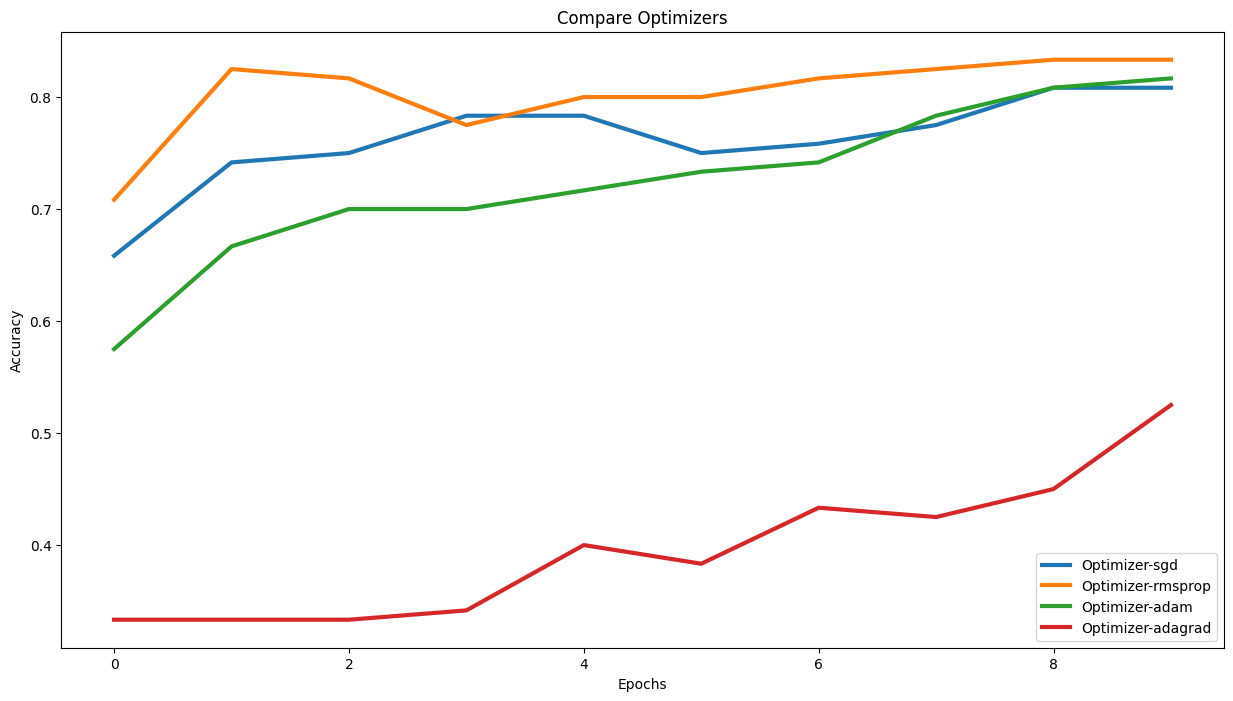

In [10]:
plot_graph(accuracy_measures, "Compare Optimizers")

## 3.6. Learning Rates

In [11]:

accuracy_measures = {}

learning_rate_list = [0.001, 0.005,0.01,0.1,0.5]
for learning_rate in learning_rate_list:
    
    model_config = base_model_config()
    X,Y = get_data()
    
    model_config["LEARNING_RATE"] = learning_rate
    model_name="Learning-Rate-" + str(learning_rate)
    history=create_and_run_model(model_config,X,Y, model_name)
    
    #accuracy
    accuracy_measures[model_name] = history.history["accuracy"]




******************************************************


c:\Users\Karthi\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "Learning-Rate-0.001"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Dense-Layer-0 (Dense)           │ (None, 32)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense-Layer-1 (Dense)           │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output-Layer (Dense)            │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,467 (9.64 KB)

 Trainable params: 2,467 (9.64 KB)

 Non-trainable params: 0 (0.00 B)


******************************************************


c:\Users\Karthi\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "Learning-Rate-0.005"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Dense-Layer-0 (Dense)           │ (None, 32)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense-Layer-1 (Dense)           │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output-Layer (Dense)            │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,467 (9.64 KB)

 Trainable params: 2,467 (9.64 KB)

 Non-trainable params: 0 (0.00 B)


******************************************************


c:\Users\Karthi\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "Learning-Rate-0.01"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Dense-Layer-0 (Dense)           │ (None, 32)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense-Layer-1 (Dense)           │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output-Layer (Dense)            │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,467 (9.64 KB)

 Trainable params: 2,467 (9.64 KB)

 Non-trainable params: 0 (0.00 B)


******************************************************


c:\Users\Karthi\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "Learning-Rate-0.1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Dense-Layer-0 (Dense)           │ (None, 32)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense-Layer-1 (Dense)           │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output-Layer (Dense)            │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,467 (9.64 KB)

 Trainable params: 2,467 (9.64 KB)

 Non-trainable params: 0 (0.00 B)


******************************************************


c:\Users\Karthi\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "Learning-Rate-0.5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Dense-Layer-0 (Dense)           │ (None, 32)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense-Layer-1 (Dense)           │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output-Layer (Dense)            │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,467 (9.64 KB)

 Trainable params: 2,467 (9.64 KB)

 Non-trainable params: 0 (0.00 B)

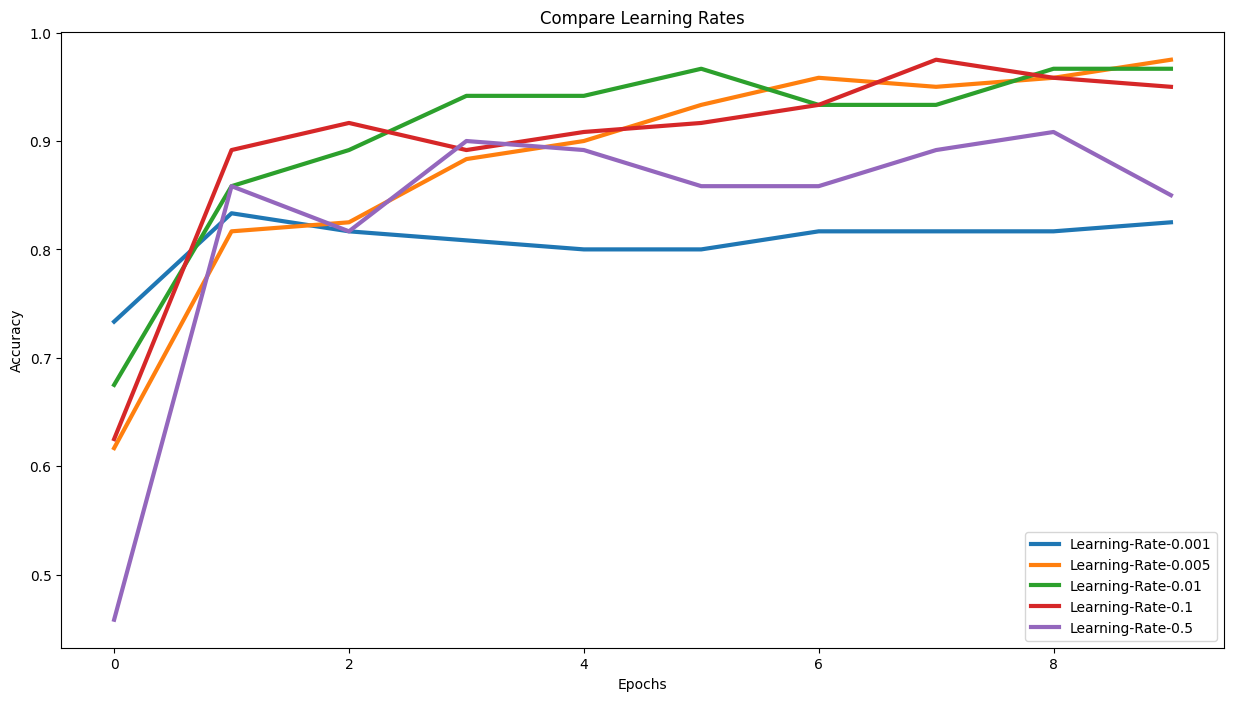

In [12]:
plot_graph(accuracy_measures, "Compare Learning Rates")

## 4.3. Regularization

In [17]:
accuracy_measures = {}

regularizer_list = ['l1','l2']
for regularizer in regularizer_list:
    
    model_config = base_model_config()
    X,Y = get_data()
    
    model_config["REGULARIZER"] = regularizer
    model_config["EPOCHS"]=25
    model_name = "Regularizer-" + regularizer
    history=create_and_run_model(model_config,X,Y, model_name)
    
    #Switch to validation accuracy
    accuracy_measures[model_name] = history.history["val_accuracy"]




******************************************************


c:\Users\Karthi\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "Regularizer-l1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Dense-Layer-0 (Dense)           │ (None, 32)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense-Layer-1 (Dense)           │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output-Layer (Dense)            │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,467 (9.64 KB)

 Trainable params: 2,467 (9.64 KB)

 Non-trainable params: 0 (0.00 B)


******************************************************


c:\Users\Karthi\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "Regularizer-l2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Dense-Layer-0 (Dense)           │ (None, 32)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense-Layer-1 (Dense)           │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output-Layer (Dense)            │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,467 (9.64 KB)

 Trainable params: 2,467 (9.64 KB)

 Non-trainable params: 0 (0.00 B)

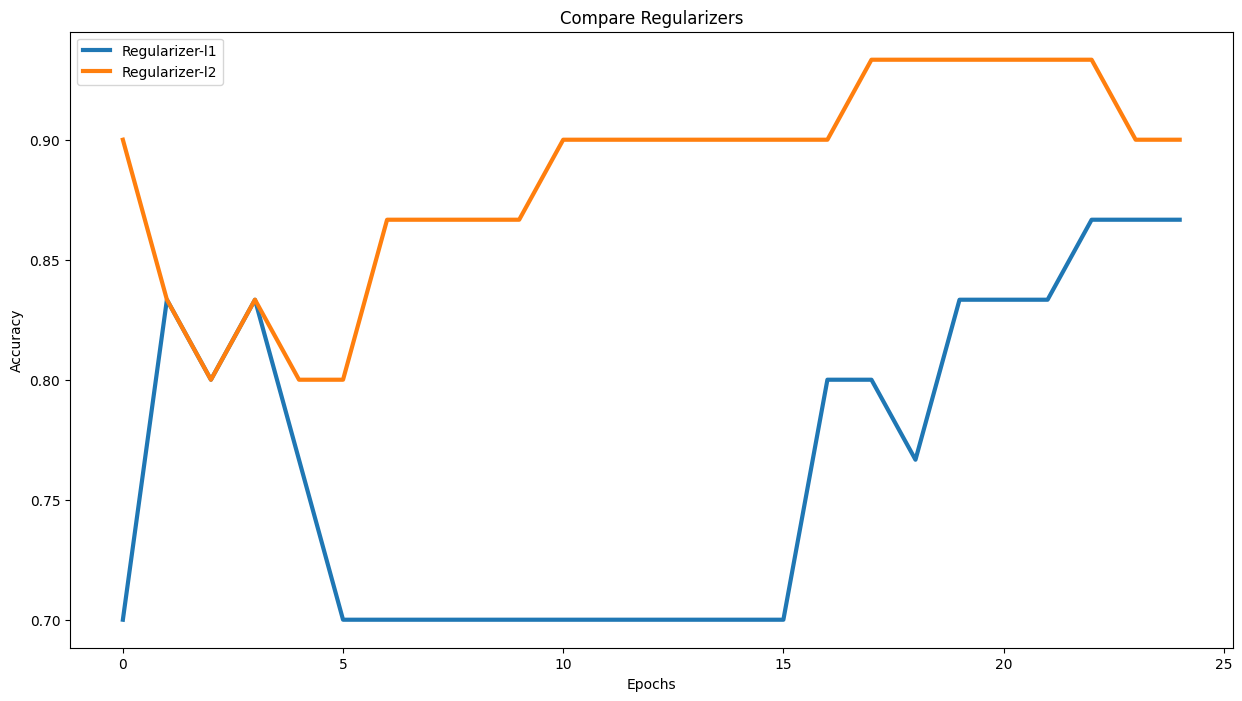

In [14]:
plot_graph(accuracy_measures, "Compare Regularizers")

## 4.5. Dropout

In [15]:
accuracy_measures = {}

dropout_list = [0.0, 0.1, 0.2, 0.5]
for dropout in dropout_list:
    
    model_config = base_model_config()
    X,Y = get_data()
    
    model_config["DROPOUT_RATE"] = dropout
    model_config["EPOCHS"]=25
    model_name="Dropout-" + str(dropout)
    history=create_and_run_model(model_config,X,Y, model_name)
    
    #Using validation accuracy
    accuracy_measures[model_name] = history.history["val_accuracy"]



******************************************************


c:\Users\Karthi\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "Dropout-0.0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Dense-Layer-0 (Dense)           │ (None, 32)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense-Layer-1 (Dense)           │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output-Layer (Dense)            │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,467 (9.64 KB)

 Trainable params: 2,467 (9.64 KB)

 Non-trainable params: 0 (0.00 B)


******************************************************


c:\Users\Karthi\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "Dropout-0.1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Dense-Layer-0 (Dense)           │ (None, 32)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense-Layer-1 (Dense)           │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output-Layer (Dense)            │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,467 (9.64 KB)

 Trainable params: 2,467 (9.64 KB)

 Non-trainable params: 0 (0.00 B)


******************************************************


c:\Users\Karthi\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "Dropout-0.2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Dense-Layer-0 (Dense)           │ (None, 32)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense-Layer-1 (Dense)           │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output-Layer (Dense)            │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,467 (9.64 KB)

 Trainable params: 2,467 (9.64 KB)

 Non-trainable params: 0 (0.00 B)


******************************************************


c:\Users\Karthi\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "Dropout-0.5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Dense-Layer-0 (Dense)           │ (None, 32)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense-Layer-1 (Dense)           │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output-Layer (Dense)            │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,467 (9.64 KB)

 Trainable params: 2,467 (9.64 KB)

 Non-trainable params: 0 (0.00 B)

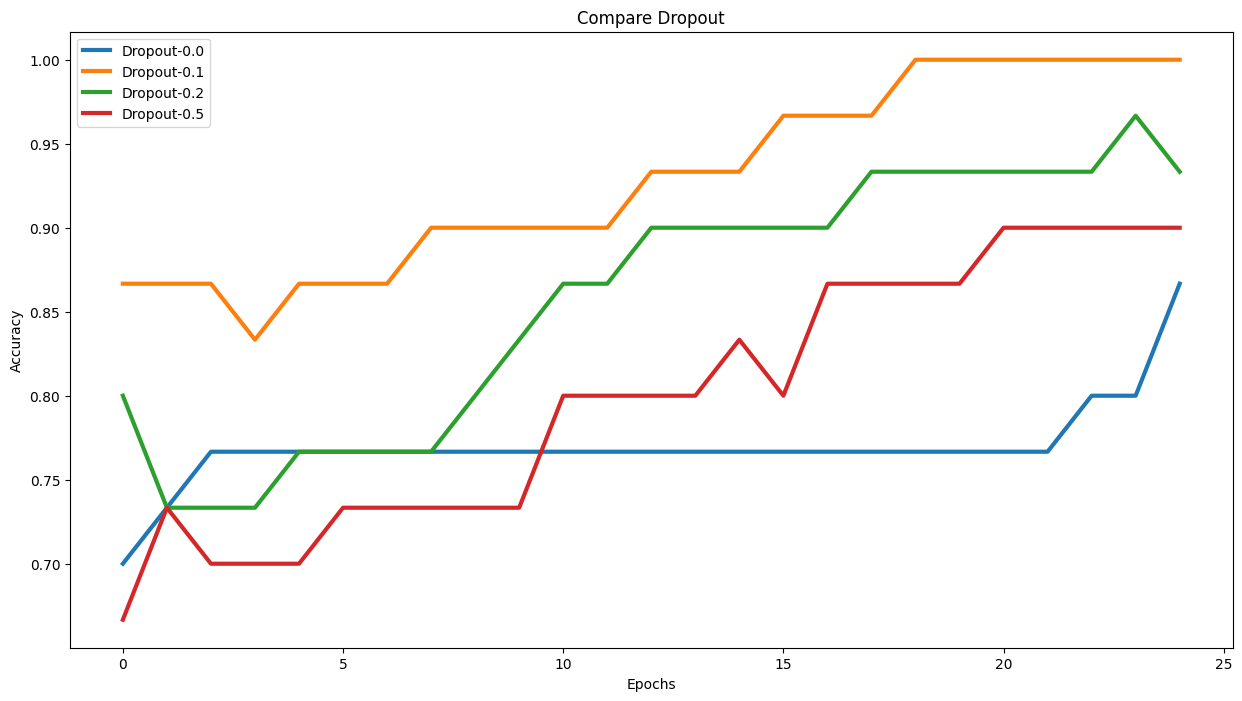

In [16]:
plot_graph(accuracy_measures, "Compare Dropout")

In [19]:
accuracy_measures = {}

#Base Minimal Model
model_config = base_model_config()
X,Y = get_data()

model_name = "Base-Model-"

history=create_and_run_model(model_config,X,Y,model_name)
    
accuracy_measures[model_name] = history.history["accuracy"]

#Adding all optimizations
model_config = base_model_config()
model_config["HIDDEN_NODES"] = [16,16]
model_config["NORMALIZATION"] = "batch"
model_config["OPTIMIZER"] = "rmsprop"
model_config["LEARNING_RATE"] = 0.01
model_config["REGULARIZER"]="l2"
model_config["DROPOUT_RATE"] = 0.1
model_config["HIDDEN_ACTIVATION"] = 'tanh'


X,Y = get_data()

model_name = "Optimized-Model-"

history=create_and_run_model(model_config,X,Y,model_name)
    
accuracy_measures[model_name] = history.history["accuracy"]

c:\Users\Karthi\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



******************************************************


Model: "Base-Model-"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Dense-Layer-0 (Dense)           │ (None, 32)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense-Layer-1 (Dense)           │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output-Layer (Dense)            │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,467 (9.64 KB)

 Trainable params: 2,467 (9.64 KB)

 Non-trainable params: 0 (0.00 B)


******************************************************


c:\Users\Karthi\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "Optimized-Model-"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Dense-Layer-0 (Dense)           │ (None, 16)             │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense-Layer-1 (Dense)           │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output-Layer (Dense)            │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 467 (1.82 KB)

 Trainable params: 435 (1.70 KB)

 Non-trainable params: 32 (128.00 B)

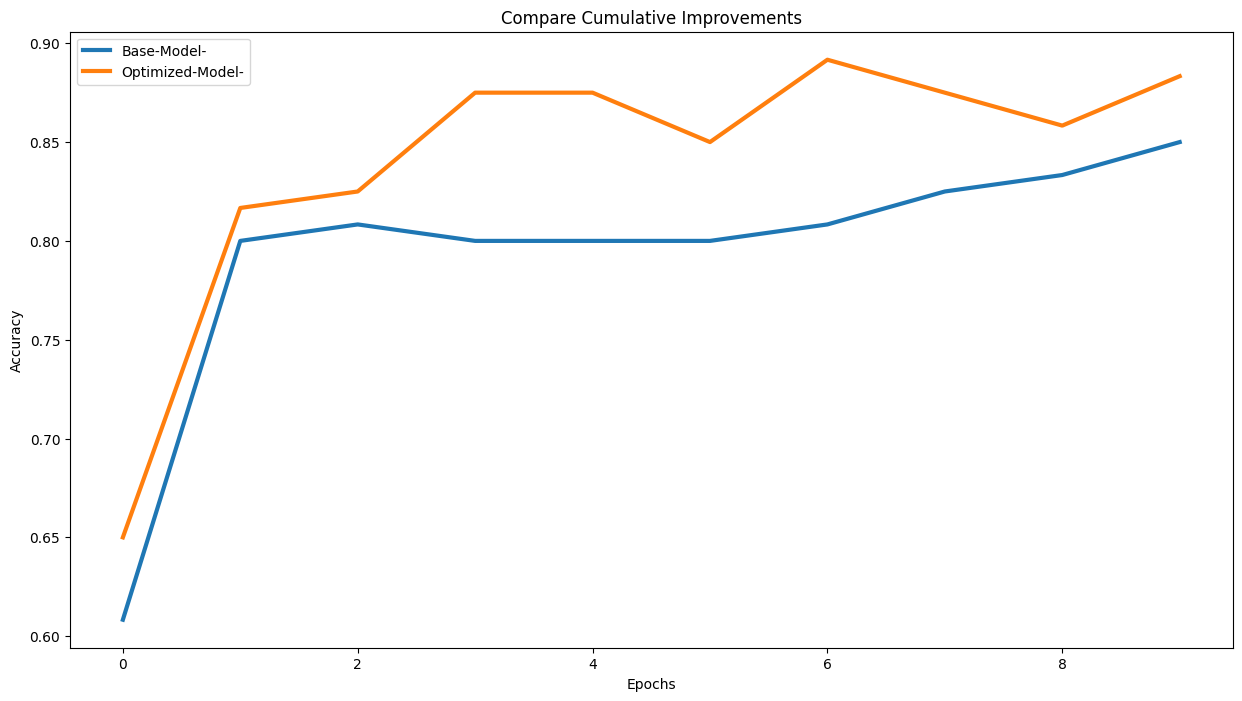

In [20]:
plot_graph(accuracy_measures, "Compare Cumulative Improvements")